<a href="https://colab.research.google.com/github/wangbxj1234/huazi/blob/main/%E5%AE%8C%E7%BE%8E%E9%87%8D%E6%9E%84%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 准备

In [1]:
!pip install compressai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.6 MB/s eta 0:00:00
  Created wheel for compressai: filename=compressai-1.2.6-cp310-cp310-linux_x86_64.whl size=405685 sha256=c07661e3e8fba98e3722910b80488b887157a2c03805aff24f42fa0d3166acf2
  Stored in directory: /root/.cache/pip/wheels/b3/e1/85/87edc5d40a531877f35ba1cfc8f66e2e76d49d4845f57c0f46
Successfully built compressai


In [2]:
import math
import torch
import torch.nn as nn
from torch import Tensor

#from compressai.ops import ste_round
from compressai.models.utils import conv, deconv

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

/usr/local/lib/python3.10/dist-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [3]:
def conv3x3(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """3x3 convolution with padding."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)

def conv1x1(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)

In [4]:
class AttentionBlock(nn.Module):
    """Self attention block.

    Simplified variant from `"Learned Image Compression with
    Discretized Gaussian Mixture Likelihoods and Attention Modules"
    <https://arxiv.org/abs/2001.01568>`_, by Zhengxue Cheng, Heming Sun, Masaru
    Takeuchi, Jiro Katto.

    Args:
        N (int): Number of channels)
    """

    def __init__(self, N: int):
        super().__init__()

        class ResidualUnit(nn.Module):
            """Simple residual unit."""

            def __init__(self):
                super().__init__()
                self.conv = nn.Sequential(
                    conv1x1(N, N // 2),
                    nn.ReLU(inplace=True),
                    conv3x3(N // 2, N // 2),
                    nn.ReLU(inplace=True),
                    conv1x1(N // 2, N),
                )
                self.relu = nn.ReLU(inplace=True)

            def forward(self, x: Tensor) -> Tensor:
                identity = x
                out = self.conv(x)
                out += identity
                out = self.relu(out)
                return out

        self.conv_a = nn.Sequential(ResidualUnit(), ResidualUnit(), ResidualUnit())

        self.conv_b = nn.Sequential(
            ResidualUnit(),
            ResidualUnit(),
            ResidualUnit(),
            conv1x1(N, N),
        )

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        a = self.conv_a(x)
        b = self.conv_b(x)
        out = a * torch.sigmoid(b)
        out += identity
        return out

In [5]:
x=torch.rand(1,3,256,256)
c=conv(3,64)
y=c(x)
y.shape

torch.Size([1, 64, 128, 128])

In [6]:
a=AttentionBlock(3)
y=a(x)
y.shape

torch.Size([1, 3, 256, 256])

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

import time


from torch import Tensor


class ResidualBottleneckBlock(nn.Module):
    """Simple residual block with two 3x3 convolutions.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
    """

    def __init__(self, in_ch: int):
        super().__init__()
        self.conv1 = conv1x1(in_ch, in_ch//2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(in_ch//2, in_ch//2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv1x1(in_ch//2, in_ch)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)

        out = out + identity
        return out


# 定义图像压缩网络
class ImageCompressionNetwork(nn.Module):
    def __init__(self, N, M):
        super(ImageCompressionNetwork, self).__init__()

        self.g_a = nn.Sequential(
            conv(3, N),  # Module 1
            ResidualBottleneckBlock(N),  # Module 2
            ResidualBottleneckBlock(N),  # Module 3
            ResidualBottleneckBlock(N),  # Module 4
            conv(N, N),  # Module 5
            ResidualBottleneckBlock(N),  # Module 6
            ResidualBottleneckBlock(N),  # Module 7
            ResidualBottleneckBlock(N),  # Module 8
            AttentionBlock(N),  # Module 9
            conv(N, N),  # Module 10
            ResidualBottleneckBlock(N),  # Module 11
            ResidualBottleneckBlock(N),  # Module 12
            ResidualBottleneckBlock(N),  # Module 13
            conv(N, M),  # Module 14
            AttentionBlock(M),  # Module 15
        )

    def forward(self, x):
        module1 = self.g_a[0](x)  # Output of Module 1
        module1_output = module1.clone()

        y2 = self.g_a[1](module1)  # Module 2
        y2 = self.g_a[2](y2)  # Module 3
        y2 = self.g_a[3](y2)  # Module 4
        module5 = self.g_a[4](y2)  # Output of Module 5
        module5_output = module5.clone()

        y3 = self.g_a[5](module5)  # Module 6
        y3 = self.g_a[6](y3)  # Module 7
        y3 = self.g_a[7](y3)  # Module 8
        y4 = self.g_a[8](y3)  # Module 9 (AttentionBlock)

        module10 = self.g_a[9](y4)  # Output of Module 10
        module10_output = module10.clone()

        y5 = self.g_a[10](module10)  # Module 11
        y5 = self.g_a[11](y5)  # Module 12
        y5 = self.g_a[12](y5)  # Module 13
        module14 = self.g_a[13](y5)  # Output of Module 14
        module14_output = module14.clone()

        final_output = self.g_a[14](module14)  # Final output after AttentionBlock

        return module1_output, module5_output, module10_output, module14_output, final_output

def save_image(tensor, filename):
    # Convert tensor to PIL image and save
    img = transforms.ToPILImage()(tensor.cpu().detach())
    img.save(filename)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = ImageCompressionNetwork(N=64, M=32)

    # Create a dummy input image
    input_image = torch.rand((1, 3, 256, 256))  # Batch size of 1, 3 channels, 256x256

    # Forward pass
    module1, module5, module10, module14, final_output = model(input_image)
    print(module1.shape)
    print(module5.shape)
    print(module10.shape)
    print(module14.shape)
    print(final_output.shape)
    # Save the outputs
    # save_image(module1[0], 'output_module1.png')
    # save_image(module5[0], 'output_module5.png')
    # save_image(module10[0], 'output_module10.png')
    # save_image(module14[0], 'output_module14.png')
    # save_image(final_output[0], 'final_output.png')


torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])


In [8]:
import torch.nn as nn
from compressai.layers import AttentionBlock

def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )

class ResidualBottleneck(nn.Module):
    def __init__(self, N=192, act=nn.ReLU) -> None:
        super().__init__()
        self.branch = nn.Sequential(
            conv1x1(N, N // 2),
            act(),
            nn.Conv2d(N // 2, N // 2, kernel_size=3, stride=1, padding=1),
            act(),
            conv1x1(N // 2, N)
        )

    def forward(self, x):
        out = x + self.branch(x)

        return out


class SynthesisTransformEX(nn.Module):
    def __init__(self, N, M, act=nn.ReLU) -> None:
        super().__init__()
        self.synthesis_transform = nn.Sequential(
            AttentionBlock(M),
            deconv(M, N),
            # injector 들어갈 구간
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, N),
            AttentionBlock(N),
            # extractor 들어갈 구간
            # injector 들어갈 구간
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, N),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, 3)
        )

    def forward(self, x):
        x = self.synthesis_transform(x)
        return x

#g_s = SynthesisTransformEX(N, M, act=nn.ReLU)

# 完整压缩模型的定义和训练

In [9]:

# 定义完整图像压缩网络
class ImageCompressionNetwork1(nn.Module):
    def __init__(self, N, M):
        super(ImageCompressionNetwork1, self).__init__()

        self.g_a = nn.Sequential(
            conv(3, N),  # Module 1
            ResidualBottleneckBlock(N),  # Module 2
            ResidualBottleneckBlock(N),  # Module 3
            ResidualBottleneckBlock(N),  # Module 4
            conv(N, N),  # Module 5
            ResidualBottleneckBlock(N),  # Module 6
            ResidualBottleneckBlock(N),  # Module 7
            ResidualBottleneckBlock(N),  # Module 8
            AttentionBlock(N),  # Module 9
            conv(N, N),  # Module 10
            ResidualBottleneckBlock(N),  # Module 11
            ResidualBottleneckBlock(N),  # Module 12
            ResidualBottleneckBlock(N),  # Module 13
            conv(N, M),  # Module 14
            AttentionBlock(M),  # Module 15
        )
        self.g_s = SynthesisTransformEX(N, M, act=nn.ReLU)

    def forward(self, x):
        y=self.g_a(x)
        x_hat=self.g_s(y)
        return x_hat



In [10]:


# Assuming your ImageCompressionNetwork1 is already defined as above

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(cifar10, batch_size=1, shuffle=True)

# Instantiate model
model = ImageCompressionNetwork1(N=192, M=320)





100%|██████████| 170498071/170498071 [00:12<00:00, 13347520.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [24]:



# Assuming your ImageCompressionNetwork1 class is defined here

# Hyperparameters
N = 192  # Number of channels for the network
M = 320  # Output channels
num_epochs = 10  # Number of training epochs
learning_rate = 0.0001
batch_size = 64

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)

# Instantiate model
model = ImageCompressionNetwork1(N=N, M=M)
model.train()  # Set to training mode

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, _ in loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, images)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




Files already downloaded and verified
Epoch [1/10], Loss: 0.0051
Epoch [2/10], Loss: 0.0041
Epoch [3/10], Loss: 0.0040
Epoch [4/10], Loss: 0.0019
Epoch [5/10], Loss: 0.0019
Epoch [6/10], Loss: 0.0016
Epoch [7/10], Loss: 0.0012
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0008
Epoch [10/10], Loss: 0.0009


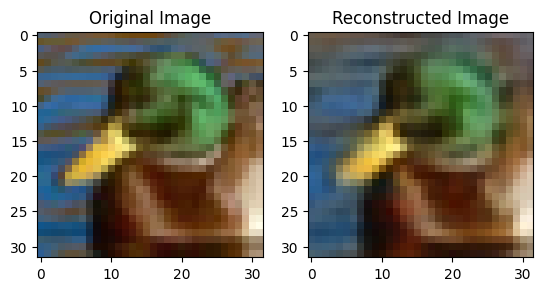

In [29]:
# Evaluate the model
model.eval()  # Set to evaluation mode
data_iter = iter(loader)
image, _ = next(data_iter)

# Forward pass for reconstruction
with torch.no_grad():
    reconstructed_image = model(image)

# Visualize original and reconstructed images
plt.subplot(1, 2, 1)
# 修改此行
plt.imshow(image[0].permute(1, 2, 0).numpy())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0].squeeze().permute(1, 2, 0).numpy())
plt.title('Reconstructed Image')

plt.show()

#  13，然后搞搞的效果不好

In [13]:


# 定义完整图像压缩网络
class ImageCompressionNetwork1(nn.Module):
    def __init__(self, N, M):
        super(ImageCompressionNetwork1, self).__init__()
        act=nn.ReLU
        self.attention=AttentionBlock(M)
        self.g_a = nn.Sequential(
            conv(3, N),  # Module 1
            ResidualBottleneckBlock(N),  # Module 2
            ResidualBottleneckBlock(N),  # Module 3
            ResidualBottleneckBlock(N),  # Module 4
            conv(N, N),  # Module 5
            ResidualBottleneckBlock(N),  # Module 6
            ResidualBottleneckBlock(N),  # Module 7
            ResidualBottleneckBlock(N),  # Module 8
            AttentionBlock(N),  # Module 9
            conv(N, N),  # Module 10
            ResidualBottleneckBlock(N),  # Module 11
            ResidualBottleneckBlock(N),  # Module 12
            ResidualBottleneckBlock(N),  # Module 13
            conv(N, M),  # Module 14
            AttentionBlock(M),  # Module 15
        )
        self.g_s = nn.Sequential(
            AttentionBlock(M),
            deconv(M, N),
            # injector 들어갈 구간
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, N),
            AttentionBlock(N),
            # extractor 들어갈 구간
            # injector 들어갈 구간
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, N),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            ResidualBottleneck(N, act=act),
            deconv(N, 13),
            AttentionBlock(13),
            nn.Conv2d(13, 3, kernel_size=1)
        )

    def forward(self, x):
        y=self.g_a(x)
        x_hat=self.g_s(y)
        return x_hat
    # def forward(self, x):
    # # 计算左上1/4区域的尺寸
    # h, w = x.size(2), x.size(3)
    # quarter_h, quarter_w = h // 4, w // 4

    # # 提取左上1/4区域
    # left_top_quarter = x[:, :, :quarter_h, :quarter_w]

    # # 转换左上1/4区域为灰度图像
    # gray_quarter = left_top_quarter.mean(dim=1, keepdim=True)  # 生成单通道

    # # 复制到3通道，形成灰度图像
    # gray_quarter = gray_quarter.repeat(1, 3, 1, 1)  # 变为3通道

    # # 创建一个与x相同大小的零矩阵
    # black_white_image = torch.zeros_like(x)

    # # 将灰度区域放回到相应的位置
    # black_white_image[:, :, :quarter_h, :quarter_w] = gray_quarter

    # # 融合 x_hat 和黑白图像
    # y = self.g_a(x)
    # x_hat = self.g_s(y)
    # fused_output = torch.cat(x_hat,black_white_image,dim=1)  #

    # # 继续经过网络
    # final_output = self.g_s(fused_output)
    # return final_output



# Assuming your ImageCompressionNetwork1 is already defined as above

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(cifar10, batch_size=1, shuffle=True)

# Instantiate model
model = ImageCompressionNetwork1(N=192, M=320)






# Assuming your ImageCompressionNetwork1 class is defined here

# Hyperparameters
N = 192  # Number of channels for the network
M = 320  # Output channels
num_epochs = 10  # Number of training epochs
learning_rate = 0.0001
batch_size = 64

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)

# Instantiate model
model = ImageCompressionNetwork1(N=N, M=M)
model.train()  # Set to training mode

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, _ in loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, images)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 0.0091
Epoch [2/10], Loss: 0.0059
Epoch [3/10], Loss: 0.0040
Epoch [4/10], Loss: 0.0029
Epoch [5/10], Loss: 0.0031
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0020
Epoch [8/10], Loss: 0.0014
Epoch [9/10], Loss: 0.0010
Epoch [10/10], Loss: 0.0012


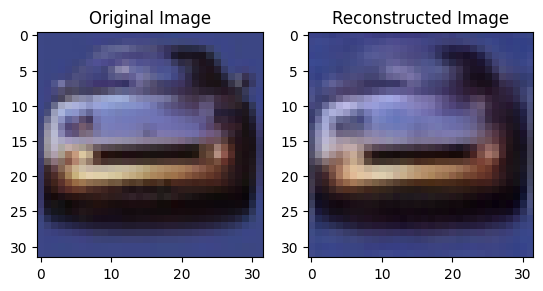

In [15]:
# Evaluate the model
model.eval()  # Set to evaluation mode
data_iter = iter(loader)
image, _ = next(data_iter)

# Forward pass for reconstruction
with torch.no_grad():
    reconstructed_image = model(image)

# Visualize original and reconstructed images
plt.subplot(1, 2, 1)
# 修改此行
plt.imshow(image[0].permute(1, 2, 0).numpy())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0].squeeze().permute(1, 2, 0).numpy())
plt.title('Reconstructed Image')

plt.show()

# 新招